In [1]:
from __future__ import division
import numpy as np
from numpy.linalg import norm
from numpy.random import rand
from numpy.random import randint
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import PIL.Image
from scipy.optimize import fmin_l_bfgs_b as minimize
import math
from random import randint

In [2]:
## ---------------------------------------------------------------
def sampleIMAGES():
    # sampleIMAGES 
    # Returns 10000 patches for training

    IMAGES = np.load('IMAGES.npy')  # load images from disk

    patchsize = 8                   # we'll use 8x8 patches 
    numpatches = 10000
    
    # Initialize patches with zeros. Your code will fill in this matrix--one
    # row per patch, 10000 rows. 
    patches = np.zeros((numpatches, patchsize*patchsize))
    
    ## ---------- YOUR CODE HERE --------------------------------------
    #  Instructions: Fill in the variable "patches" using data 
    #  from IMAGES.  
    #  
    #  IMAGES is a 3D array containing 10 images,
    #  and Python indexes arrays by starting from 0.
    #  For instance, IMAGES[:,:,0] is a 512x512 array containing the 1st image,
    #  and to visualize it you can type 
    #      from matplotlib import pyplot as plt
    #      plt.imshow(IMAGES[:,:,0])
    #      plt.set_cmap('gray')
    #      plt.show()
    #  (The contrast on these images look a bit off because they have
    #  been preprocessed using using "whitening."  See the lecture notes for
    #  more details.) As a second example, IMAGES[20:30,20:30,1] is an image
    #  patch corresponding to the pixels in the block (20,20) to (29,29) of
    #  Image 2
    
#     print(IMAGES)
#     print(type(IMAGES))
#     print(IMAGES.shape)


#     print(patches.shape)

    for i in range(numpatches):
        
        image_index = randint(0, 9)
#         print(image_index)
        
        start_index1 = randint(0, 512-patchsize)
        
        end_index1 = start_index1 + patchsize;
        
        start_index2 = randint(0, 512-patchsize)
        
        end_index2 = start_index2 + patchsize;
        
#         print(start_index1)
#         print(start_index2)
#         print(end_index1)
#         print(end_index2)
        
        
        patch = IMAGES[start_index1:end_index1, start_index2:end_index2, image_index]
        
#        print(patch.shape)
#         print(patch.size)
        
        
        temp = np.reshape(patch, (patchsize*patchsize))
#         print(temp.shape)
        
        patches[i,:] = temp
        
#         print("\n")
    #print(patches[9999])

#     ## ---------------------------------------------------------------
#     # For the autoencoder to work well we need to normalize the data
#     # Specifically, since the output of the network is bounded between [0,1]
#     # (due to the sigmoid activation function), we have to make sure 
#     # the range of pixel values is also bounded between [0,1]
    patches = normalizeData(patches)
    return patches

#print(sampleIMAGES())

In [3]:
## ---------------------------------------------------------------
def normalizeData(patches):
    # Squash data to [0.1, 0.9] since we use sigmoid as the activation
    # function in the output layer
    
    # Remove DC (mean of images). 
    patches = patches-np.array([np.mean(patches,axis=1)]).T
        
    # Truncate to +/-3 standard deviations and scale to -1 to 1
    pstd = 3*np.std(patches)
    patches = np.fmax(np.fmin(patches,pstd),-pstd)/pstd
    
    # Rescale from [-1,1] to [0.1,0.9]
    patches = (patches+1)*0.4+0.1    
    return patches

In [97]:
## ---------------------------------------------------------------
def sparseAutoencoderCost(theta,visibleSize,hiddenSize,decayWeight,sparsityParam,beta,data):
    # visibleSize: the number of input units (probably 64) 
    # hiddenSize: the number of hidden units (probably 25) 
    # decayWeight: weight decay parameter lambda
    # sparsityParam: The desired average activation for the hidden units (denoted in the lecture
    #                           notes by the greek alphabet rho, which looks like a lower-case "p").
    # beta: weight of sparsity penalty term
    # data: Our 10000x64 matrix containing the training data.  So, data[i-1,:] is the i-th training example. 
      
    # The input theta is a vector (because scipy.optimize.fmin_l_bfgs_b expects the parameters to be a vector). 
    # We first convert theta to the (W1, W2, b1, b2) matrix/vector format, so that this 
    # follows the notation convention of the lecture notes.     
    W1,W2,b1,b2 = unravelParameters(theta,hiddenSize,visibleSize)

    # Cost and gradient variables (your code needs to compute these values). 
    # Here, we initialize them to zeros. 
    cost = 0
    W1grad = np.zeros(np.shape(W1))
    W2grad = np.zeros(np.shape(W2))
    b1grad = np.zeros(np.shape(b1))
    b2grad = np.zeros(np.shape(b2))
    
    ## ---------- YOUR CODE HERE --------------------------------------
    #  Instructions: Compute the cost/optimization objective J_sparse(W,b) for the Sparse Autoencoder,
    #                and the corresponding gradients W1grad, W2grad, b1grad, b2grad.
    #
    # W1grad, W2grad, b1grad and b2grad should be computed using backpropagation.
    # Note that W1grad has the same dimensions as W1, b1grad has the same dimensions
    # as b1, etc.  Your code should set W1grad to be the partial derivative of J_sparse(W,b) with
    # respect to W1.  I.e., W1grad(i,j) should be the partial derivative of J_sparse(W,b) 
    # with respect to the input parameter W1(i,j).  Thus, W1grad should be equal to the term 
    # [(1/m) \Delta W^{(1)} + \lambda W^{(1)}] in the last block of pseudo-code in Section 2.2 
    # of the lecture notes (and similarly for W2grad, b1grad, b2grad).
    # 
    # Stated differently, if we were using batch gradient descent to optimize the parameters,
    # the gradient descent update to W1 would be W1 := W1 - alpha * W1grad, and similarly for W2, b1, b2. 
    # 

    m = data.shape[0]
    
    # forward pass
    A1 = data
    z2 = A1 @ W1 + b1
    A2 = sigmoid(z2)
    z3 = A2 @ W2 + b2
    A3 = sigmoid(z3)

    error = A1 - A3

    # calculate estimated activiation value, rho.
    rho = 1 / m * np.sum(A2,1).reshape(-1,1)

    # backprop with rho
    delta3 = -(A1 - A3) * A3 * (1 - A3)
    
    temp1 = delta3 @ W2.T
    
    temp2 = beta * (-sparsityParam / rho + (1 - sparsityParam) / (1 - rho))
    
    temp3 = temp1 + temp2
    
    temp4 = A2 * (1-A2)
    
    temp5 = temp3 * temp4
    
    #delta2 = (W2.T @ delta3 + beta_ * (-sparsityParam / rho + (1 - sparsityParam) / (1 - rho))) * A2 * (1 - A2)

    W2grad = delta3.T @ A2
    W1grad = temp5.T @ A1
    
    #print(delta3.shape)
    #print(temp5.shape)
    b2grad = np.sum(delta3,0).reshape(-1,1)
    b1grad = np.sum(temp5,0).reshape(-1,1)

    W2grad = 1/m * W2grad + (decayWeight * W2).T
    W1grad = 1/m * W1grad + (decayWeight * W1).T
    b2grad = 1/m * b2grad
    b1grad = 1/m * b1grad

    # compute cost and adjust costs with regularization and sparsity constriants
    mean_squared_error = 1 / m * np.sum(error**2)
    regularization_part = decayWeight / 2 * sum([np.sum(W1**2), np.sum(W2**2)])
    sparsity_part = sparsityParam * np.log(sparsityParam / rho) + (1 - sparsityParam) * np.log((1 - sparsityParam) / (1 - rho))
    cost = 0.5 * mean_squared_error + regularization_part + beta * np.sum(sparsity_part)



#     #-------------------------------------------------------------------
#     # After computing the cost and gradient, we will convert the gradients back
#     # to a vector format (suitable for scipy.optimize.fmin_l_bfgs_b).  
    grad = ravelParameters(W1grad,W2grad,b1grad,b2grad)
    return cost,grad

In [5]:
## ---------------------------------------------------------------
def sigmoid(x):
    # Here's an implementation of the sigmoid function, which you may find useful
    # in your computation of the costs and the gradients.  This inputs a (row or
    # column) vector (say (z1, z2, z3)) and returns (f(z1), f(z2), f(z3)). 
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))



def KL_divergence(x, y):

    return x * np.log(x / y) + (1 - x) * np.log((1 - x) / (1 - y))

## ---------------------------------------------------------------
def unravelParameters(theta,hiddenSize,visibleSize):
    # Convert theta to the (W1, W2, b1, b2) matrix/vector format
    W1 = theta[0:hiddenSize*visibleSize].reshape(visibleSize,hiddenSize)
    W2 = theta[hiddenSize*visibleSize:2*hiddenSize*visibleSize].reshape(hiddenSize,visibleSize)
    b1 = theta[2*hiddenSize*visibleSize:2*hiddenSize*visibleSize+hiddenSize]
    b2 = theta[2*hiddenSize*visibleSize+hiddenSize:]
    return W1,W2,b1,b2
    

## ---------------------------------------------------------------
def ravelParameters(W1,W2,b1,b2):
    # Unroll the (W1, W2, b1, b2) matrix/vector format to the theta format.
    return np.concatenate((W1.ravel(),W2.ravel(),b1.ravel(),b2.ravel()))


## ---------------------------------------------------------------
def checkNumericalGradient():
    # This code can be used to check your numerical gradient implementation 
    # in computeNumericalGradient()
    # It analytically evaluates the gradient of a very simple function called
    # simpleQuadraticFunction (see below) and compares the result with your numerical
    # solution. Your numerical gradient implementation is incorrect if
    # your numerical solution deviates too much from the analytical solution.

    # Evaluate the function and gradient at x = [4; 10]; (Here, x is a 2d vector.)
    x = np.array([4,10])
    value,grad = simpleQuadraticFunction(x)
    
    # Use your code to numerically compute the gradient of simpleQuadraticFunction at x.
    # (The notation "lambda x: simpleQuadraticFunction(x)[0]" creates a function
    # that only returns the cost and not the grad of simpleQuadraticFunction.)
    numgrad = computeNumericalGradient(lambda x: simpleQuadraticFunction(x)[0],x)
    
    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar. 
    print (np.array([numgrad,grad]).T)
    print ("The above two columns you get should be very similar.")
    print ("(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n")
    
    # Evaluate the norm of the difference between two solutions.  
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    # in computeNumericalGradient.m, then diff below should be 2.1452e-12 
    diff = norm(numgrad-grad)/norm(numgrad+grad)
    print (diff)
    print ("Norm of the difference between numerical and analytical gradient (should be < 1e-9)\n\n")


## ---------------------------------------------------------------
def simpleQuadraticFunction(x):
    # this function accepts a 2D vector as input. 
    # Its outputs are:
    #   value: h(x1, x2) = x1^2 + 3*x1*x2
    #   grad: A 2-dim vector that gives the partial derivatives of h with respect to x1 and x2
    value = x[0]**2+3*x[0]*x[1]
    grad = np.zeros(np.shape(x))
    grad[0] = 2*x[0]+3*x[1]
    grad[1] = 3*x[0]
    return value, grad

In [6]:
## ---------------------------------------------------------------
def computeNumericalGradient(J,theta):
    # numgrad = computeNumericalGradient(J, theta)
    # theta: a vector of parameters
    # J: a function that outputs a real-number. 
    # Calling y = J(theta) will return the function value at theta. 
      
    # Initialize numgrad with zeros
    numgrad = np.zeros(np.shape(theta))

    ## ---------- YOUR CODE HERE --------------------------------------
    # Instructions: 
    # Implement numerical gradient checking, and return the result in numgrad.  
    # (See Section 2.3 of the lecture notes.)
    # You should write code so that numgrad(i) is (the numerical approximation to) the 
    # partial derivative of J with respect to the i-th input argument, evaluated at theta.  
    # I.e., numgrad(i) should be the (approximately) the partial derivative of J with 
    # respect to theta(i).
    #               
    # Hint: You will probably want to compute the elements of numgrad one at a time. 


    epsilon = 1e-4
    num = len(theta)
    e = np.eye(num)
    
    #print(e.shape)
    
    for i in range(num):
        numgrad[i] = (J(theta + epsilon * e[i]) - J(theta - epsilon * e[i])) / (2* epsilon)
        
        
        if i % 100 == 0:

            print ("Computing gradient for input:", i)


    ## ---------------------------------------------------------------
    return numgrad

In [7]:
## ---------------------------------------------------------------
def initializeParameters(hiddenSize,visibleSize):
    # Initialize parameters randomly based on layer sizes.
    r = np.sqrt(6)/np.sqrt(hiddenSize+visibleSize+1)
    W1 = rand(visibleSize,hiddenSize)*2*r-r
    W2 = rand(hiddenSize,visibleSize)*2*r-r
    b1 = np.zeros((hiddenSize,1))
    b2 = np.zeros((visibleSize,1))

    # Convert weights and bias gradients to the vector form.
    # This step will "unroll" (flatten and concatenate together) all 
    # your parameters into a vector, which can then be used 
    # with scipy.optimize.fmin_l_bfgs_b. 
    theta = ravelParameters(W1,W2,b1,b2)    
    return theta


## ---------------------------------------------------------------
def displayNetwork(A,optNormEach=False,optNormAll=True,numColumns=None,imageWidth=None,cmapName='gray',
                   borderColor='blue',borderWidth=1,verbose=True,graphicsLibrary='matplotlib',saveName=''):
    # This function visualizes filters in matrix A. Each row of A is a
    # filter. We will reshape each row into a square image and visualizes
    # on each cell of the visualization panel. All other parameters are
    # optional, usually you do not need to worry about them.
    #
    # optNormEach: whether we need to normalize each row so that 
    # the mean of each row is zero.
    #
    # optNormAll: whether we need to normalize all the rows so that 
    # the mean of all the rows together is zero.
    #
    # imageWidth: how many pixels are there for each image
    # Default value is the squareroot of the number of columns in A.
    #
    # numColumns: how many columns are there in the display. 
    # Default value is the squareroot of the number of rows in A.
 
    # compute number of rows and columns    
    nr,nc = np.shape(A) 
    if imageWidth==None:
        sx = np.ceil(np.sqrt(nc))
        sy = np.ceil(nc/sx)
    else:
        sx = imageWidth
        sy = np.ceil(nc/sx)
    if numColumns==None:
        n = np.ceil(np.sqrt(nr))
        m = np.ceil(nr/n)
    else:
        n = numColumns
        m = np.ceil(nr/n)
    n = np.uint8(n)
    m = np.uint8(m)
    if optNormAll:    
        A = A-A.min()
        A = A/A.max()
     
    # insert data onto squares on the screen
    k = 0
    buf = borderWidth
    sy = int(sy)
    sx = int(sx)
    array = -np.ones([buf+m*(sy+buf),buf+n*(sx+buf)])
    for i in range(1,m+1):
        for j in range(1,n+1):
            if k>=nr: 
                continue
            B = A[k,:]
            if optNormEach:
                B = B-B.min()
                B = B/float(B.max())           
            B = np.reshape(np.concatenate((B,-np.ones(sx*sy-nc)),axis=0),(sx,-1))
            array[(buf+(i-1)*(sy+buf)):(i*(sy+buf)),(buf+(j-1)*(sx+buf)):(j*(sx+buf))] = B
            k = k+1       
     
    # display picture and save it
    cmap = plt.cm.get_cmap(cmapName)
    cmap.set_under(color=borderColor)
    cmap.set_bad(color=borderColor)
    if graphicsLibrary=='PIL':
        im = PIL.Image.fromarray(np.uint8(cmap(array)*255))
        if verbose:
            im.show()
        if saveName!='':
            im.save(saveName)
    elif graphicsLibrary=='matplotlib':
        plt.imshow(array,interpolation='nearest',
                   norm=colors.Normalize(vmin=0.0,vmax=1.0,clip=False))
        plt.set_cmap(cmap)
        if verbose:
            plt.show()
        if saveName!='':
            plt.savefig(saveName)


## ---------------------------------------------------------------
class SparseAutoencoder():
    
    def __init__(self,visibleSize,hiddenSize=25,sparsityParam=0.01,beta=3,decayWeight=0.0001):
        # hyperparameters
        self.visibleSize = visibleSize      # number of input units
        self.hiddenSize = hiddenSize        # number of hidden units
        self.sparsityParam = sparsityParam  # desired average activation of hidden units
        self.beta = beta                    # weight of sparsity penalty term
        self.decayWeight = decayWeight      # weight decay parameter
        # parameters
        self.W1 = None  # array of shape (visibleSize, hiddenSize)
        self.W2 = None  # array of shape (hiddenSize, visibleSize)
        self.b1 = None  # vector of length (hiddenSize)
        self.b2 = None  # vector of length (visibleSize)

    def fit(self,patches,maxiter=400):
        # this function trains the weights of the sparse autoencoder. 
        if (self.W1 is None or self.W2 is None or self.b1 is None or self.b2 is None):
            theta = initializeParameters(self.hiddenSize,self.visibleSize)
        else:
            theta = ravelParameters(self.W1,self.W2,self.b1,self.b2)
        sparseAutoencoderArgs = (self.visibleSize,self.hiddenSize,self.decayWeight,
                                 self.sparsityParam,self.beta,patches)
        opttheta,cost,messages = minimize(sparseAutoencoderCost,theta,fprime=None,
                                          args=sparseAutoencoderArgs,maxiter=400)
        self.W1,self.W2,self.b1,self.b2 = unravelParameters(opttheta,self.hiddenSize,self.visibleSize)
        
    def predict(self,samples):
        # this function returns the output layer activations (estimates)
        z2 = np.dot(samples,self.W1)+np.array([self.b1])
        a2 = sigmoid(z2)
        z3 = np.dot(a2,self.W2)+np.array([self.b2])
        a3 = sigmoid(z3)
        return a3

    def score(self,patches):
        # computes the cost function of the sparseAutoencoder
        theta = ravelParameters(self.W1,self.W2,self.b1,self.b2)
        return sparseAutoencoderCost(theta,self.visibleSize,self.hiddenSize,self.decayWeight,
                                     self.sparsityParams,self.beta,patches)[0]

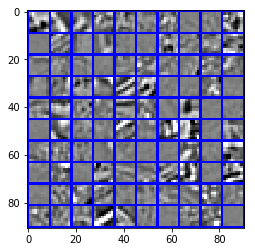

Computing gradient for input: 0
[[ 38.  38.]
 [ 12.  12.]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)


2.14523815695e-12
Norm of the difference between numerical and analytical gradient (should be < 1e-9)


Computing numerical gradient of sparseAutoencoderCost...
Computing gradient for input: 0
Computing gradient for input: 100
Computing gradient for input: 200
Computing gradient for input: 300
Computing gradient for input: 400
Computing gradient for input: 500
Computing gradient for input: 600
Computing gradient for input: 700
Computing gradient for input: 800
Computing gradient for input: 900
Computing gradient for input: 1000
Computing gradient for input: 1100
Computing gradient for input: 1200
Computing gradient for input: 1300
Computing gradient for input: 1400
Computing gradient for input: 1500
Computing gradient for input: 1600
Computing gradient for input: 1700
Computing gradient for input: 1800
Computing gra

In [98]:
if __name__ == "__main__":
    #  This function contains code that helps you get started on the
    #  programming assignment. You will need to complete the code in 
    #  sampleIMAGES(), sparseAutoencoderCost() and computeNumericalGradient(). 
    #  For the purpose of completing the assignment, you do not need to
    #  change the code in this function. 
    #
    ##======================================================================
    ## STEP 0: Here we provide the relevant parameters values that will
    #  allow your sparse autoencoder to get good filters; you do not need to 
    #  change the parameters below.
    
    visibleSize = 8*8      # number of input units 
    hiddenSize = 25        # number of hidden units 
    sparsityParam = 0.01   # desired average activation of the hidden units.
                           # (This was denoted by the Greek alphabet rho, which
                           # looks like a lower-case "p" in the lecture notes). 
    decayWeight = 0.0001   # weight decay parameter       
    beta = 3               # weight of sparsity penalty term       
    
    ##======================================================================
    ## STEP 1: Implement sampleIMAGES
    #
    #  After implementing sampleIMAGES, the display_network command should
    #  display a random sample of 200 patches from the dataset
    
    patches = sampleIMAGES()
    displayNetwork(patches[:100,:])
    
    #  Obtain random parameters theta
    theta = initializeParameters(hiddenSize, visibleSize);
    
#     ##======================================================================
#     ## STEP 2: Implement sparseAutoencoderCost
#     #
#     #  You can implement all of the components (squared error cost, weight decay term,
#     #  sparsity penalty) in the cost function at once, but it may be easier to do 
#     #  it step-by-step and run gradient checking (see STEP 3) after each step.  We 
#     #  suggest implementing the sparseAutoencoderCost function using the following steps:
#     #
#     #  (a) Implement forward propagation in your neural network, and implement the 
#     #      squared error term of the cost function.  Implement backpropagation to 
#     #      compute the derivatives.  Then (using decayWeight=beta=0), run Gradient Checking 
#     #      to verify that the calculations corresponding to the squared error cost 
#     #      term are correct.
#     #
#     #  (b) Add in the weight decay term (in both the cost function and the derivative
#     #      calculations), then re-run Gradient Checking to verify correctness. 
#     #
#     #  (c) Add in the sparsity penalty term, then re-run Gradient Checking to 
#     #      verify correctness.
#     #
#     #  Feel free to change the training settings when debugging your
#     #  code.  (For example, reducing the training set size or 
#     #  number of hidden units may make your code run faster; and setting beta 
#     #  and/or lambda to zero may be helpful for debugging.)  However, in your 
#     #  final submission of the visualized weights, please use parameters we 
#     #  gave in Step 0 above.
    
    cost,grad = sparseAutoencoderCost(theta,visibleSize,hiddenSize,
                                      decayWeight,sparsityParam,beta,patches)

#     ##======================================================================
#     ## STEP 3: Gradient Checking
#     #
#     # Hint: If you are debugging your code, performing gradient checking on smaller models 
#     # and smaller training sets (e.g., using only 10 training examples and 1-2 hidden 
#     # units) may speed things up.
    
#     # First, lets make sure your numerical gradient computation is correct for a
#     # simple function.  After you have implemented computeNumericalGradient(),
#     # run the following: 
    checkNumericalGradient()
    
#     # Now we can use it to check your cost function and derivative calculations
#     # for the sparse autoencoder.  
    print ("Computing numerical gradient of sparseAutoencoderCost...")
    numgrad = computeNumericalGradient(lambda x: sparseAutoencoderCost(
        x,visibleSize,hiddenSize,decayWeight,sparsityParam,beta,patches)[0],theta)

# #     # Use this to visually compare the gradients side by side
    print (np.array([numgrad,grad]).T)
    
# #     # Compare numerically computed gradients with the ones obtained from backpropagation
    diff = norm(numgrad-grad)/norm(numgrad+grad)
    print (diff)  # Should be small. In our implementation, these values are
                 # usually less than 1e-9.
    
#                 # When you got this working, Congratulations!!!
 
#     ##======================================================================
#     ## STEP 4: After verifying that your implementation of
#     #  sparseAutoencoderCost() is correct, You can start training your sparse
#     #  autoencoder with scipy.optimize.fmin_l_bfgs_b (L-BFGS).
    
#     #  Randomly initialize the parameters
#     theta = initializeParameters(hiddenSize,visibleSize)
    
#     #  Use L-BFGS to minimize the function. Generally,
#     #  for scipy.optimize.fmin_l_bfgs_b to work, you
#     #  need a function with two outputs: the
#     #  function value and the gradient. In our problem,
#     #  sparseAutoencoderCost() satisfies this.
#     #  Here, we set the maximum number of iterations 
#     #  of L-BFGS to run to be 400 (or until convergence).
#     opttheta,cost,messages=minimize(sparseAutoencoderCost,theta,fprime=None,maxiter=400,
#                                     args=(visibleSize,hiddenSize,decayWeight,sparsityParam,beta,patches))
            
#     ##======================================================================
#     ## STEP 5: Visualization 
#     # save the visualization to a file 
    
#     W1,W2,b1,b2 = unravelParameters(opttheta,hiddenSize,visibleSize)w
#     displayNetwork(W1.T,saveName='weights.png') 

#     ##======================================================================
#     ## STEP 6: Classes and objects
#     # bind the functions together into a SparseAutoencoder class
#     sae = SparseAutoencoder(visibleSize=64,hiddenSize=25,sparsityParam=0.01,
#                             beta=3,decayWeight=0.0001)
#     sae.fit(patches,maxiter=2000)
#     displayNetwork(sae.W1.T,saveName='weights_2000.png')
#     estimates = sae.predict(patches[:100,:])
#     displayNetwork(estimates)